# **Курсовая работа ученика ПМ21-5 Шарапова М.А.**

## **Машинное обучение в задачах классификации звуковых сигналов автомобилей экстренных служб для беспилотных автомобилей**


In [73]:
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import os
import random
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [2]:
import matplotlib.pyplot as plt

------------------------------------------------------------------------------------------------------------
# Введение

Для беспилотного автомобиля критически важно правильно распознавать звуки сирены автомобилей экстренных служб по нескольким основным причинам:

**1) Безопасность пассажиров и окружающих: Звук сирены экстренных служб служит предупреждением о возможной аварийной ситуации или приближении экстренного транспорта. Распознавание этого звука позволяет беспилотному автомобилю принимать соответствующие меры для обеспечения безопасности пассажиров и других участников дорожного движения. Например, автомобиль может корректировать свою траекторию, снижать скорость или остановиться, чтобы предоставить дорогу автомобилю экстренных служб.**

**2) Соблюдение законодательства: В различных странах существуют законодательные требования, регулирующие поведение водителей при приближении автомобилей экстренных служб с включенной сиреной. Беспилотные автомобили также должны соответствовать этим требованиям и уступать дорогу автомобилям экстренных служб. Распознавание звука сирены позволяет автоматической системе беспилотного автомобиля реагировать соответствующим образом и выполнять необходимые маневры.**

**3) Оптимизация движения: Распознавание звука сирены автомобилей экстренных служб позволяет беспилотному автомобилю более эффективно управлять движением на дороге. Оно помогает автомобилю прогнозировать действия экстренных автомобилей, рассчитывать оптимальные маршруты и предпринимать предварительные меры для облегчения проезда автомобилей экстренных служб. Это способствует снижению задержек и повышению эффективности движения на дороге.**

Способность беспилотного автомобиля правильно распознавать звуки сирены автомобилей экстренных служб является неотъемлемым аспектом для обеспечения безопасности, соблюдения правил дорожного движения и оптимизации движения беспилотных автомобилей.

Цель работы: Определять к какому классу у меня будет относится звук сирен автомобилей экстренных служб

------------------------------------------------------------------------------------------

# Подготовка данных

Для работы я собрал 4 аудифоайла:\
**1) аудиофайл со звуком сирены автмобиля скорой помощи(Sirena1)**\
**2) аудифойл со звуком сирены автомобиля полиции(Sirena2)**\
**3) аудиофайл со звуком сирены автомобиля пожарной службы(Sirena3)**\
**4) аудиофайл со звуками едующих автомобилей(AnySounds)**

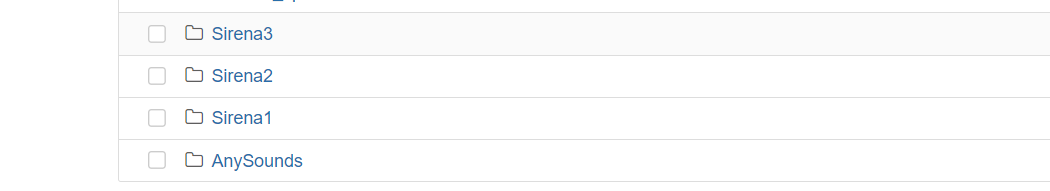

In [ ]:
audio_file = 'Sirena3/Siren 3 Full2.wav'
y, sr = librosa.load(audio_file, sr=None)

# Удаление первой секунды для того, чтобы изменить шаг для разбиения
y = y[sr:]

# Сохранение нового звукового файла без первой секунды
sf.write('Sirena3/Siren 3 Full3.wav', y, sr)



**После того, как были созданы еще аудиофайлы с изменненым шагом, я разбил все аудиофайлы в папках на фрагменты по 3 секунды, чтобы собрать больше данных для датасета**

In [ ]:
# Папка с исходными файлами
source_folder = 'Sirena1'
# Папка для сохранения файлов
target_folder = 'Sirena1_split'
# Длина фрагмента в секундах
duration = 3

os.makedirs(target_folder, exist_ok=True)

# проверка
for filename in os.listdir(source_folder):
    if not filename.endswith('.wav'):
        continue

    # Загрузить исходный файл
    audio_file = os.path.join(source_folder, filename)
    y, sr = librosa.load(audio_file, sr=None)

    # Вычислить количество фрагментов в файле
    n_segments = len(y) // (sr * duration)

    # Разбить файл на фрагменты
    for i in range(n_segments):
        start = i * sr * duration
        end = start + sr * duration
        file_name = f'{filename.split(".")[0]}_{i+1}.wav'
        target_path = os.path.join(target_folder, file_name)
        sf.write(target_path, y[start:end], sr)


В каждой папке сохранилось не равное друг другу количество фрагментов. Для дальнейшей работы мне нужно сблансировать классы:

In [ ]:
folders = ['Sirena1_split', 'Sirena2_split', 'Sirena3_split', 'AnySounds_split']
num_files_to_keep = 1412

for folder in folders:
    path = folder
    files = os.listdir(path)
    num_files_to_delete = len(files) - num_files_to_keep
    files_to_delete = random.sample(files, num_files_to_delete)
    for file in files_to_delete:
        os.remove(os.path.join(path, file))

Чтобы квалифицировать звуки сирен, я решил выбрать способ преобразования фрагмента звука в спектрограмму.
Для классификации звуков спектрограммы используются потому, что они предоставляют информацию о спектральном содержании звука в течение времени. Спектрограмма представляет собой двухмерное представление звукового сигнала, где по оси времени - x, отображается изменение звука, а по оси частот - y, отображается распределение энергии звука в различных частотных диапазонах.

Спектрограмма позволяет извлекать различные спектральные характеристики звука. Эти характеристики могут быть важными признаками для классификации звуков.

Главным преимуществом такого метода является сжатие размерности. Спектрограммы представляют собой сжатое представление звукового сигнала. Вместо работы с оригинальным временным сигналом, спектрограмма позволяет работать с двухмерным массивом, что может существенно снизить размерность данных и упростить процесс классификации

In [ ]:
# Создание папок
for i in range(1, 5):
    if not os.path.exists(f"Picture{i}_split"):
        os.mkdir(f"Picture{i}_split")

# Извлечение спектрограмм и сохранение их
for i in range(1, 5):
    folder_name = f"Sirena{i}_split" if i < 4 else "AnySounds_split"
    for j, file_name in enumerate(os.listdir(folder_name)):
        file_path = os.path.join(folder_name, file_name)

        # Загрузка
        y, sr = librosa.load(file_path, sr=None)

        # Извлечение спектрограмм
        S = librosa.stft(y)
        S_db = librosa.amplitude_to_db(abs(S), ref=np.max)

        # Отрисовывание спектрограммы
        plt.figure(figsize=(4, 4), dpi=100)
        librosa.display.specshow(S_db, x_axis='time', y_axis='log')
        plt.axis('off')
        plt.tight_layout()

        # Сохранение изображения
        picture_path = os.path.join(f"Picture{i}_split", f"{j+1}.png")
        plt.savefig(picture_path, bbox_inches='tight', pad_inches=0)

        plt.close()


# Описание датасета

Проверяем на сблансированность классов

In [4]:
len('Picture1_split') == len('Picture2_split') == len('Picture3_split') == len('Picture4_split')

True

Визуализация

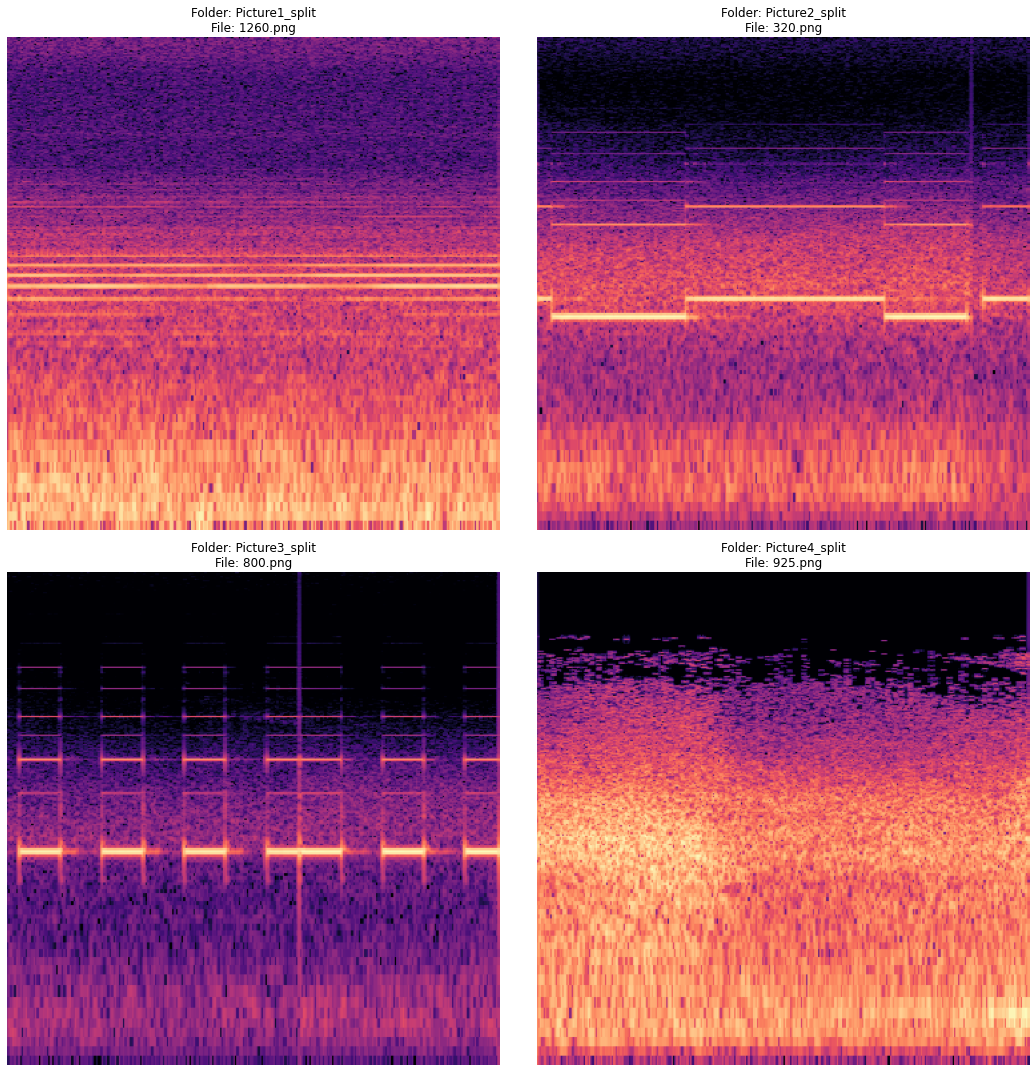

In [5]:
folder_list = ["Picture1_split", "Picture2_split", "Picture3_split", "Picture4_split"]

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Проход по каждой папке
for i, folder_name in enumerate(folder_list):
    folder_path = folder_name
    file_list = os.listdir(folder_path)

    # Выбор случайного файла из папки
    random_file = random.choice(file_list)
    file_path = os.path.join(folder_path, random_file)
        
    image = cv2.imread(file_path)
        
    # Визуализация изображения
    ax = axs[i // 2, i % 2]
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Folder: {folder_name}\nFile: {random_file}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Модели

In [165]:
picture_folders = ["Picture1_split", "Picture2_split", "Picture3_split", "Picture4_split"]
X = []
y = []

In [166]:
for i, folder in enumerate(picture_folders):
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        # Проверка на формат файла
        if file_name.endswith('.png'):
            # Загрузка изображения
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            # Параметры изображения
            img = cv2.resize(img, (50, 50))
            # Добавление изображения и метки класса 
            X.append(img)
            y.append(i)

In [167]:
#Преобразование в списки numpy
X = np.array(X)
y = np.array(y)

In [168]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1) Случайный лес

In [158]:
%%time
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

Wall time: 5.66 s


RandomForestClassifier(random_state=42)

In [159]:
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       308
           1       0.98      0.95      0.97       266
           2       0.95      0.97      0.96       274
           3       1.00      1.00      1.00       282

    accuracy                           0.98      1130
   macro avg       0.98      0.98      0.98      1130
weighted avg       0.98      0.98      0.98      1130



Чтоб не было переобучения

In [169]:
%%time
# Использование модели RandomForestClassifier с регуляризацией
clf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', random_state=42)

clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Оцениваем точность модели на тестовых данных
y_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.95      0.99      0.97       308
           1       0.99      0.99      0.99       266
           2       0.98      0.94      0.96       274
           3       1.00      1.00      1.00       282

    accuracy                           0.98      1130
   macro avg       0.98      0.98      0.98      1130
weighted avg       0.98      0.98      0.98      1130

Wall time: 354 ms


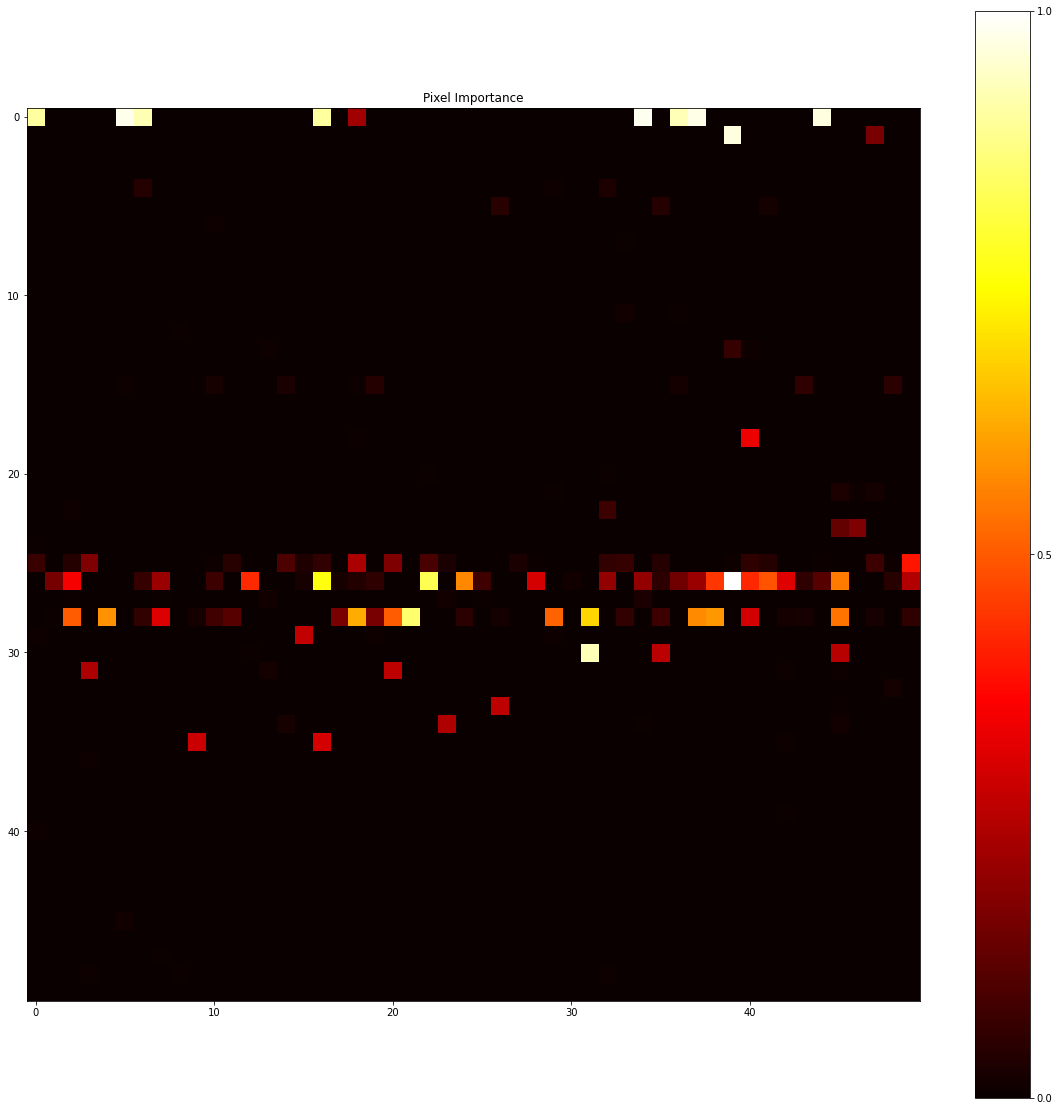

In [171]:
# Получаем важность пикселей
importances = clf.feature_importances_

# Создаем сетку пикселей размером 50x50
grid = importances.reshape((50, 50))

# Нормализуем значения важности пикселей в диапазон от 0 до 1
normalized_grid = grid / grid.max()

# Выводим сетку пикселей с процентным представлением
plt.figure(figsize=(20, 20))
plt.imshow(normalized_grid, cmap='hot', interpolation='nearest')
plt.title("Pixel Importance")
plt.colorbar(ticks=[0, 0.5, 1]) 
plt.show()



В данном коде я вычисляю важность пикселей для модели случайного леса. Имея обученную модель RandomForestClassifier (clf), мы получаем значения важности пикселей с помощью метода feature_importances_. Затем мы создаем сетку пикселей размером 50x50, где каждый пиксель представляет важность для модели. Для удобства визуализации, значения важности нормализуются в диапазоне от 0 до 1. В конце я вывожу сетку пикселей, где более важные пиксели отображаются более яркими цветами, позволяя визуально оценить вклад каждого пикселя в процесс классификации.

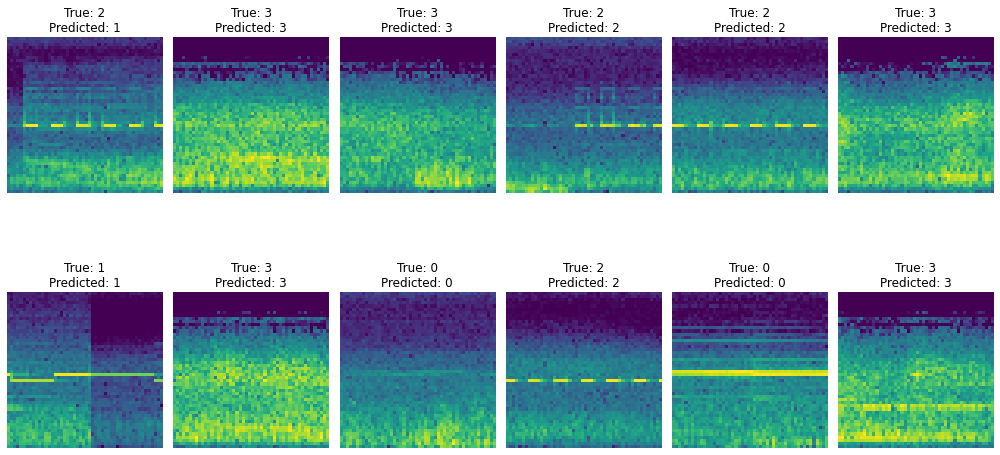

In [89]:
# Выбираем несколько случайных изображений из тестового набора
num_images = 12
random_indices = np.random.choice(range(len(X_test)), num_images, replace=False)
images = X_test[random_indices]
true_labels = y_test[random_indices]

# Получение предсказанных меток классов

predicted_labels = clf.predict(images.reshape(images.shape[0], -1))

# Выводим изображения и соответствующие метки
fig, axes = plt.subplots(2, num_images // 2, figsize=(14, 8))
for i in range(num_images):
    row = i // (num_images // 2)
    col = i % (num_images // 2)

    axes[row, col].imshow(images[i])
    axes[row, col].set_title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


2) Метод опорных выкторов

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
%%time
svm_clf = SVC(kernel='rbf', gamma='auto')
svm_clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

y_pred = svm_clf.predict(X_test.reshape(X_test.shape[0], -1))

# Оцениваем точность предсказаний
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       308
           1       0.24      1.00      0.38       266
           2       0.00      0.00      0.00       274
           3       0.00      0.00      0.00       282

    accuracy                           0.24      1130
   macro avg       0.06      0.25      0.10      1130
weighted avg       0.06      0.24      0.09      1130

Wall time: 31.4 s


C:\Users\Max Sharapov\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max Sharapov\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Max Sharapov\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [163]:
%%time
svm_clf = SVC(kernel='rbf', gamma='scale')
svm_clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

y_pred = svm_clf.predict(X_test.reshape(X_test.shape[0], -1))

# Оцениваем точность предсказаний
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       308
           1       0.97      0.98      0.97       266
           2       0.98      0.97      0.97       274
           3       1.00      1.00      1.00       282

    accuracy                           0.99      1130
   macro avg       0.99      0.99      0.99      1130
weighted avg       0.99      0.99      0.99      1130

Wall time: 3.47 s


3) К ближайших соседей

In [164]:
%%time
# Создание и обучение модели KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Прогнозирование на тестовых данных
y_pred = knn_clf.predict(X_test.reshape(X_test.shape[0], -1))

# Оценка точности модели
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       308
           1       0.98      0.99      0.99       266
           2       0.99      0.96      0.97       274
           3       1.00      1.00      1.00       282

    accuracy                           0.99      1130
   macro avg       0.99      0.99      0.99      1130
weighted avg       0.99      0.99      0.99      1130

Wall time: 177 ms


4) Решающие деревья

In [94]:
%%time
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Прогнозирование на тестовых данных
y_pred = tree_clf.predict(X_test.reshape(X_test.shape[0], -1))

# Оценка точности модели
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.91      0.90      0.90       308
           1       0.92      0.95      0.94       266
           2       0.90      0.89      0.90       274
           3       1.00      0.99      0.99       282

    accuracy                           0.93      1130
   macro avg       0.93      0.93      0.93      1130
weighted avg       0.93      0.93      0.93      1130

Wall time: 2.19 s


5) Логистическая регрессия

In [142]:
%%time
# Преобразование изображений в векторы признаков
X_flattened = X_train.reshape(X_train.shape[0], -1)

# Создание и обучение модели логистической регрессии с параметрами
logreg = LogisticRegression(max_iter=10)
logreg.fit(X_flattened, y_train)

# Преобразование тестовых данных в векторы признаков
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Предсказание классов для тестовых данных
y_pred = logreg.predict(X_test_flattened)

# Оценка точности модели
report = classification_report(y_test, y_pred)
print(report)



              precision    recall  f1-score   support

           0       0.91      0.87      0.89       308
           1       0.87      0.97      0.91       266
           2       0.96      0.90      0.93       274
           3       1.00      1.00      1.00       282

    accuracy                           0.93      1130
   macro avg       0.93      0.93      0.93      1130
weighted avg       0.93      0.93      0.93      1130

Wall time: 288 ms


C:\Users\Max Sharapov\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


6) Наивный байесовский классификатор

In [141]:
%%time
# Преобразование изображений в векторы признаков
X_flattened = X_train.reshape(X_train.shape[0], -1)

# Создание и обучение модели наивного байесовского классификатора
naive_bayes = GaussianNB()
naive_bayes.fit(X_flattened, y_train)

# Преобразование тестовых данных в векторы признаков
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Предсказание классов для тестовых данных
y_pred = naive_bayes.predict(X_test_flattened)

# Оценка точности модели  
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.74      0.81      0.77       308
           1       0.53      0.85      0.65       266
           2       0.80      0.26      0.39       274
           3       1.00      1.00      1.00       282

    accuracy                           0.73      1130
   macro avg       0.77      0.73      0.70      1130
weighted avg       0.77      0.73      0.71      1130

Wall time: 212 ms


Улучшение модели

In [140]:
%%time
# Создание и обучение модели мультиномиального наивного байесовского классификатора
naive_bayes = MultinomialNB(alpha=1.0)  
naive_bayes.fit(X_flattened, y_train)

# Преобразование тестовых данных в векторы признаков
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Предсказание классов для тестовых данных
y_pred = naive_bayes.predict(X_test_flattened)

# Оценка точности модели
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.86      0.81      0.84       308
           1       0.82      0.89      0.85       266
           2       0.88      0.85      0.86       274
           3       0.99      1.00      1.00       282

    accuracy                           0.89      1130
   macro avg       0.89      0.89      0.89      1130
weighted avg       0.89      0.89      0.89      1130

Wall time: 129 ms


В первой модели, precision и recall имеют ниже значения для классов 1 и 2, в сравнении со улученной моделью. Это означает, что модель имеет более низкую точность и полноту в определении этих классов в сравнении со второй.

F1-score для классов 1 и 2 также ниже в первом отчете, что указывает на более слабую сбалансированную оценку модели для этих классов.

Однако, в первом отчете модель достигла более высокой точности и полноты для класса 0. Также стоит отметить, что accuracy в первом отчете составляет 0.73, в то время как во втором отчете - 0.89. Это указывает на лучшую общую производительность модели во втором отчете, где она правильно классифицировала 89% образцов.

В целом, второй отчет демонстрирует лучшие результаты по метрикам точности, полноты, F1-score и accuracy, что говорит о лучшей производительности модели в сравнении с первым отчетом.

7) Градиентный бустинг

In [139]:
%%time
# Создание и обучение модели градиентного бустинга
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Предсказание классов для тестовых данных
y_pred = gb_classifier.predict(X_test.reshape(X_test.shape[0], -1))

# Оценка точности модели
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       308
           1       1.00      1.00      1.00       266
           2       1.00      0.98      0.99       274
           3       1.00      1.00      1.00       282

    accuracy                           1.00      1130
   macro avg       1.00      1.00      1.00      1130
weighted avg       1.00      1.00      1.00      1130

Wall time: 9min 47s


# Cравнение моделей при увелечении количества признаков

Для сравнения я взял модель мультиномиального наивного байесовского классификатора. Я увеличил количество пикселей с **50х50** на **250х250**

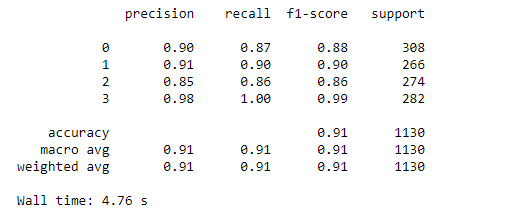
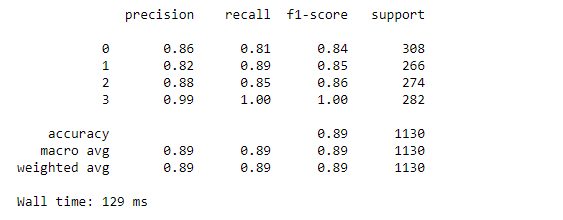

Можно заметить, что качество модели улучшилось на 0.02(2%), но время на запуск кода был тоже увеличен

# Вывод

В ходе работы для классификации звуков были приведены несколько моделей для предсказания к какому классу относится звук,  это важная задача, потому что это позволяет беспилотным автомобилям эффективно распознавать и отличать звуковые сигналы автомобилей экстренных служб, таких как сирены полиции, пожарных или скорой помощи. Это имеет решающее значение для обеспечения безопасности и эффективности автономного движения.

Дальнейшее развитие этой работы может включать улучшение моделей классификации, использование более сложных алгоритмов обработки звука и расширение набора классов для более точной классификации различных звуковых сигналов экстренных автомобилей. Также можно провести дополнительные исследования по оптимизации моделей и интеграции их в системы беспилотных автомобилей для реального времени обнаружения и реагирования на экстренные ситуации на дороге.
